# How to debug a model

## Introduction
モデルをデバッグするにはさまざまなレベルがあります。 最も簡単な方法の 1 つは、さまざまな変数がとっている値を単に出力することです。

```PyMC``` は関数ではなく ```PyTensor``` 式を使用してモデルを構築するため、 ```print``` ステートメントを尤度関数に配置する方法はありません。 代わりに、 [pytensor.printing.Print](https://pytensor.readthedocs.io/en/latest/library/printing.html#pytensor.printing.Print) クラスを使用して中間値を出力できます。

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 8927

### How to print intermediate values of ```PyTensor``` functions
```PyTensor``` 関数は C にコンパイルされるため、中間値 (以下では ```Print``` としてインポート) を出力するには ```pytensor.printing.Print``` クラスを使用する必要があります。 Python ```print``` 関数は動作しません。 以下は ``Print`` を使用する簡単な例です。 詳細については、「[PyTensor のデバッグ](https://pytensor.readthedocs.io/en/latest/tutorial/debug_faq.html#debug-faq)」を参照してください。

In [3]:
import pytensor.tensor as pt

from pytensor import function
from pytensor.printing import Print

In [4]:
x = pt.dvector("x")
y = pt.dvector("y")
func = function([x, y], 1 / (x - y))
func([1, 2, 3], [1, 0, -1])

array([ inf, 0.5 , 0.25])

出力に ```inf``` 値が表示される原因を確認するには、```Print``` を使用して $(x - y)$ の中間値を出力します。
```Print``` クラスは単に呼び出し元を渡しますが、その値をユーザー定義のメッセージに沿って出力します。

In [5]:
z_with_print = Print("x - y = ")(x - y)
func_with_print = function([x, y], 1 / z_with_print)
func_with_print([1, 2, 3], [1, 0, -1])

x - y =  __str__ = [0. 2. 4.]


array([ inf, 0.5 , 0.25])

```Print``` は根本原因を明らかにします。$x = 1、y = 1$ の場合、$(x - y)$ はゼロ値をとり、```inf``` 出力が発生します。

### How to capture ```Print``` output for further analysis
```Print``` からの出力が多数の行になることが予想される場合、出力を文字列バッファにリダイレクトし、後で値にアクセスすることが望ましい場合があります (この例を発案してくれた **Lindley Lentati** に感謝します)。 以下は Python ```print``` 関数を使用したおもちゃの例です。

In [6]:
import sys

from io import StringIO

old_stdout = sys.stdout
mystdout = sys.stdout = StringIO()

for i in range(5):
    print(f"Test values: {i}")

output = mystdout.getvalue().split("\n")
sys.stdout = old_stdout  # setting sys.stdout back
output

['Test values: 0',
 'Test values: 1',
 'Test values: 2',
 'Test values: 3',
 'Test values: 4',
 '']

### Troubleshooting a toy PyMC model


In [7]:
rng = np.random.default_rng(RANDOM_SEED)
x = rng.normal(size=100)

with pm.Model() as model:
    # priors
    mu = pm.Normal("mu", mu=0, sigma=1)
    sd = pm.Normal("sd", mu=0, sigma=1)

    # setting out printing for mu and sd
    mu_print = Print("mu")(mu)
    sd_print = Print("sd")(sd)

    # likelihood
    obs = pm.Normal("obs", mu=mu_print, sigma=sd_print, observed=x)

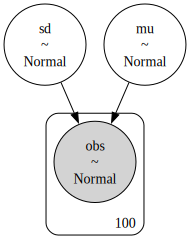

In [8]:
pm.model_to_graphviz(model)

In [9]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(5, step, tune=0, chains=1, progressbar=False, random_seed=RANDOM_SEED)

TypeError: sample() takes from 0 to 1 positional arguments but 2 positional arguments (and 4 keyword-only arguments) were given

PyMC v4 の例外処理が改善されたため、SamplingError 例外は ```-inf``` の可能性をもたらした ```mu``` と ```sd``` の中間値を出力するようになりました。
ただし、```aeasara.printing.Print``` を使用して中間値を出力するこの手法は、より複雑な場合に役立ちます。

### Bringing it all together

In [10]:
rng = np.random.default_rng(RANDOM_SEED)
y = rng.normal(loc=5, size=20)

old_stdout = sys.stdout
mystdout = sys.stdout = StringIO()

with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=10)
    a = pm.Normal("a", mu=0, sigma=10, initval=0.1)
    b = pm.Normal("b", mu=0, sigma=10, initval=0.1)
    sd_print = Print("Delta")(a / b)
    obs = pm.Normal("obs", mu=mu, sigma=sd_print, observed=y)

    # limiting number of samples and chains to simplify output
    trace = pm.sample(draws=10, tune=0, chains=1, progressbar=False, random_seed=RANDOM_SEED)

output = mystdout.getvalue()
sys.stdout = old_stdout  # setting sys.stdout back

Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu, a, b]
Sampling 1 chain for 0 tune and 10 draw iterations (0 + 10 draws total) took 0 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The number of samples is too small to check convergence reliably.


In [11]:
output

'Delta __str__ = -85.74093608165128\nDelta __str__ = -9.182002291671038\nDelta __str__ = 0.10737295473067673\nDelta __str__ = 0.10737295473067673\nDelta __str__ = 0.10737295473067673\nDelta __str__ = -9.315734173890057\nDelta __str__ = 0.10737295473067673\nDelta __str__ = -9.312485782438435\nDelta __str__ = 0.10737295473067673\nDelta __str__ = -9.314669656412734\nDelta __str__ = 0.10737295473067673\nDelta __str__ = -9.315816191570379\nDelta __str__ = 0.10737295473067673\nDelta __str__ = -9.315114719133613\nDelta __str__ = 0.10737295473067673\nDelta __str__ = -9.315110404793872\nDelta __str__ = 0.10737295473067673\nDelta __str__ = -9.314077394936476\nDelta __str__ = 0.10737295473067673\nDelta __str__ = -9.313673830463395\nDelta __str__ = 0.10737295473067673\nDelta __str__ = -9.315610253397129\nDelta __str__ = 0.10737295473067673\nDelta __str__ = -9.315265693700571\n'

生の出力は少し乱雑で、numpy.ndarray に変換するにはクリーンアップとフォーマット設定が必要です。
以下の例では、正規表現を使用して出力をクリーンアップし、それを ``eval`` で評価して浮動小数点数のリストを取得します。
以下のコードは、高次元の出力でも機能します (さまざまなモデルを実験したい場合に備えて)。

In [12]:
import re

# output cleanup and conversion to numpy array
# this is code accepts more complicated inputs
pattern = re.compile("Delta __str__ = ")
output = re.sub(pattern, " ", output)
pattern = re.compile("\\s+")
output = re.sub(pattern, ",", output)
pattern = re.compile(r"\[,")
output = re.sub(pattern, "[", output)
output += "]"
output = "[" + output[1:]
output = eval(output)
output = np.array(output)

In [13]:
output

array([-85.74093608,  -9.18200229,   0.10737295,   0.10737295,
         0.10737295,  -9.31573417,   0.10737295,  -9.31248578,
         0.10737295,  -9.31466966,   0.10737295,  -9.31581619,
         0.10737295,  -9.31511472,   0.10737295,  -9.3151104 ,
         0.10737295,  -9.31407739,   0.10737295,  -9.31367383,
         0.10737295,  -9.31561025,   0.10737295,  -9.31526569])

5 回の抽選をリクエストしましたが、34 セットの抽選を獲得したことに注目してください。
  価値観。 その理由は、反復ごとに、提案されたすべての値 (受け入れられた値だけでなく) が出力されるためです。 負の値には明らかに問題があります。

In [14]:
output.shape

(24,)

## Authors
* Authored by Thomas Wiecki in July, 2016
* Updated by Igor Kuvychko in August, 2022 ([pymc#406] (https://github.com/pymc-devs/pymc-examples/pull/406))

## Watermark

In [15]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,xarray

Last updated: Fri Apr 05 2024

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

pytensor: 2.19.0
xarray  : 2024.3.0

numpy     : 1.26.4
arviz     : 0.17.1
pymc      : 5.12.0
re        : 2.2.1
sys       : 3.11.8 | packaged by conda-forge | (main, Feb 16 2024, 20:40:50) [MSC v.1937 64 bit (AMD64)]
matplotlib: 3.8.3
pandas    : 2.2.1
pytensor  : 2.19.0

Watermark: 2.4.3



## License notice
All the notebooks in this example gallery are provided under the [MIT License](https://github.com/pymc-devs/pymc-examples/blob/main/LICENSE) which allows modification, and redistribution for any use provided the copyright and license notices are preserved.

## Citing PyMC examples
To cite this notebook, use the DOI provided by Zenodo for the pymc-examples repository.

````
```Important
Many notebooks are adapted from other sources: blogs, books… In such cases you should cite the original source as well.

Also remember to cite the relevant libraries used by your code.
```
````
Here is an citation template in bibtex:

which once rendered could look like:

Igor Kuvychko , Thomas Wiecki . "How to debug a model". In: PyMC Examples. Ed. by PyMC Team. DOI: [10.5281/zenodo.5654871](https://zenodo.org/records/7487077)